In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image

In [3]:
from constants import *

In [4]:
import matplotlib.pyplot as plt

### Old way of pulling out corpus

In [5]:
with open(f'{CONCAT_DIR}/concat_corpus.utf') as f:
    train_contents = f.read()

In [6]:
train_contents[0:10]

'їPÿ\x07{\x919\x05)\x1c'

In [7]:
import h5py    
import numpy as np    
import json
concat_h5 = h5py.File(f'{CONCAT_DIR}/concat_corpus.h5','r+') 

concat_json = json.load(open(f'{CONCAT_DIR}/concat_corpus.json', 'rb'))

/home/paperspace/anaconda3/envs/music/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
t = concat_h5['train']

In [9]:
t[:10]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

### One hot encoding

In [10]:
def one_hot(a,c): 
    return np.eye(c)[a]

In [11]:
class MusicDataset(torch.utils.data.Dataset):
    """Face Landmarks dataset."""

    def __init__(self, h5_file, set_type, json_file, timesteps, root_dir):
        self.concat_h5 = h5py.File(f'{root_dir}/{h5_file}','r+')
        self.dataset = self.concat_h5[set_type]
        self.concat_json = json.load(open(f'{root_dir}/{json_file}', 'rb'))
        self.vocab_size = len(self.concat_json['idx_to_token'])+1
        self.data_length = self.dataset.shape[0]
        self.timesteps = timesteps

    def __len__(self):
#         print((self.data_length - self.timesteps)//10)
#         return (self.data_length - self.timesteps)//10
        return (self.data_length // self.timesteps)

    def __getitem__(self, idx):
#         print(np.arange(10)[0:8]) # example
#         print(np.arange(10)[8])
        # (AS) Should not have duplicate sequences. 
        # RBMs do not actually use target value, so no point in repeating next char
#         x = self.dataset[idx:idx+timesteps]
#         y = self.dataset[idx+timesteps]
        
        start = idx*self.timesteps
        x = self.dataset[start:start+self.timesteps]
        y = self.dataset[start+1:start+self.timesteps+1]
#         x_hot = one_hot(x, self.vocab_size)
        return x, y


In [13]:
batch_size = 64
timesteps = 64
md = MusicDataset(h5_file='concat_corpus.h5', set_type='train', json_file='concat_corpus.json', timesteps=timesteps, root_dir=CONCAT_DIR)

In [14]:
train_loader = torch.utils.data.DataLoader(md,
    batch_size=batch_size)

### Dataset sanity test

In [15]:
train_iter = enumerate(train_loader)

In [16]:
i, (x, y) = next(train_iter)
i2, (x2, y2) = next(train_iter)

In [17]:
md.dataset[:100]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  6,  6,  6, 11,  3, 12, 13,
        6, 14,  8, 15, 16,  6, 14,  8,  4, 16,  6, 14,  8,  9, 16,  6,  2,
       17, 18, 19,  6,  7, 20, 21, 22,  6, 23, 20, 21, 22,  6, 24, 20, 21,
       22,  6, 25,  3, 26, 27,  6, 28,  8, 29, 30,  6, 23,  8, 29, 30,  6,
       24,  8, 29, 30,  6,  2, 17, 18, 31,  6,  7, 20, 21, 32,  6,  7, 20,
        4,  5,  6,  7, 20,  9, 10,  6, 23, 26, 12, 18,  6, 24, 29],
      dtype=uint8)

In [18]:
# a = np.argmax(x[11], axis=1)[:-1]
# b = np.argmax(x[10], axis=1)[1:]
# np.testing.assert_array_equal(a, b)

In [19]:
# a = np.argmax(x2[0], axis=1)[:-1]
# b = np.argmax(x[-1], axis=1)[1:]
# np.testing.assert_array_equal(a, b)

### Model

In [22]:
def repackage_var(h):
    """Wraps h in new Variables, to detach them from their history."""
    return torch.autograd.Variable(h.data).cuda() if type(h) == torch.autograd.Variable else tuple(repackage_var(v) for v in h)

In [23]:
class StatefulLSTM(torch.nn.Module):
    def __init__(self, scale_size, n_hidden, n_factors, bs, nl):
        super().__init__()
        self.scale_size = scale_size
        self.nl = nl
        self.embedding = torch.nn.Embedding(scale_size, n_factors)
        
        self.rnn1 = torch.nn.LSTM(n_factors, n_hidden, nl, dropout=0.5, batch_first=True).cuda()
        self.rnn2 = torch.nn.LSTM(n_hidden, n_hidden, nl, dropout=0.5, batch_first=True).cuda()
        self.rnn3 = torch.nn.LSTM(n_hidden, n_hidden, nl, dropout=0.5, batch_first=True).cuda()
        
        self.bn1 = nn.utils.weight_norm(self.rnn1, 'weight_hh_l0')
        self.bn1 = nn.utils.weight_norm(self.bn1, 'weight_ih_l0')
        self.bn2 = nn.utils.weight_norm(self.rnn2, 'weight_hh_l0')
        self.bn2 = nn.utils.weight_norm(self.bn2, 'weight_ih_l0')
        self.bn3 = nn.utils.weight_norm(self.rnn3, 'weight_hh_l0')
        self.bn3 = nn.utils.weight_norm(self.bn3, 'weight_ih_l0')
        
        # pytorch rnn does not currently work with batchnorm
        self.l_out = torch.nn.Linear(n_hidden, scale_size)
        self.n_hidden = n_hidden
        self.h1 = self.init_hidden(bs)
        self.h2 = self.init_hidden(bs)
        self.h3 = self.init_hidden(bs)
        self.bs = bs
        
    def forward(self, notes):
        bs = notes.shape[0]
        if self.h1[0].size(1) != bs: 
            print('batch size is not same size as original:', bs)
            self.h1 = self.init_hidden(bs)
            self.h2 = self.init_hidden(bs)
            self.h3 = self.init_hidden(bs)
        emb = self.embedding(notes)
#         outp1,h1 = self.rnn1(emb, self.h1)
        outp1,h1 = self.bn1(emb, self.h1)
        outp2,h2 = self.bn2(outp1, self.h2)
        outp3,h3 = self.bn3(outp2, self.h3)
        self.h1 = repackage_var(h1)
        self.h2 = repackage_var(h2)
        self.h3 = repackage_var(h3)
        return torch.nn.functional.log_softmax(self.l_out(outp3), dim=-1).view(-1, self.scale_size)
#         return torch.nn.functional.log_softmax(self.l_out(outp[:, -1, :]), dim=-1)
#         return torch.nn.functional.softmax(self.l_out(outp[:, -1, :]), dim=-1)
    
    def init_hidden(self, bs):
        h1 = torch.autograd.Variable(torch.zeros(self.nl, bs, self.n_hidden))
        h2 = torch.autograd.Variable(torch.zeros(self.nl, bs, self.n_hidden))
        return (h1.cuda(), h2.cuda())
#         if self._cuda():
#             self.h = (h1.cuda(), h2.cuda())
#         else:
#             self.h = (h1, h2)
            
    def _cuda(self):
        return next(self.parameters()).is_cuda

### Training

In [24]:
m = StatefulLSTM(md.vocab_size, n_hidden=256, n_factors=10, bs=batch_size, nl=2).cuda()

In [25]:
train_op = torch.optim.Adam(m.parameters(), lr=1e-3)

In [26]:
loss_fn = torch.nn.NLLLoss()

In [29]:
display_step = 100
training_steps = 20
for step in range(training_steps):
# for step in tqdm(range(training_steps)):
    for i, (data,target) in enumerate(train_loader):
        data, target = torch.autograd.Variable(data.long().cuda()), torch.autograd.Variable(target.long().cuda())
        m.zero_grad()
        forward = m(data)
        loss = loss_fn(forward, target.view(-1))
        loss.backward()
        train_op.step()
        if (i+1 % display_step == 0):
            print(f'Iteration: {i+1} Loss: {loss.data[0]}')
    print(f'Step: {step} Loss: {loss.data[0]}')

batch size is not same size as original: 64
batch size is not same size as original: 47
Step: 0 Loss: 0.819291353225708
batch size is not same size as original: 64
batch size is not same size as original: 47
Step: 1 Loss: 0.8088663816452026
batch size is not same size as original: 64
batch size is not same size as original: 47
Step: 2 Loss: 0.7852809429168701
batch size is not same size as original: 64
batch size is not same size as original: 47
Step: 3 Loss: 0.7748987674713135
batch size is not same size as original: 64
batch size is not same size as original: 47
Step: 4 Loss: 0.7552627325057983
batch size is not same size as original: 64
batch size is not same size as original: 47
Step: 5 Loss: 0.7502336502075195
batch size is not same size as original: 64
batch size is not same size as original: 47
Step: 6 Loss: 0.7364137768745422
batch size is not same size as original: 64
batch size is not same size as original: 47
Step: 7 Loss: 0.725136399269104
batch size is not same size as ori

### Saving model

In [30]:
model_path = f'{OUT_DIR}/../models/bachbot_stackedlstm_rnn_t64.h5'

In [31]:
torch.save(m.state_dict(), model_path)

In [ ]:
m.load_state_dict(torch.load(model_path))

### Generate music

Need to have unknown state 0?

In [32]:
timesteps = md.timesteps

In [33]:
gen_song = md.dataset[:timesteps]

In [34]:
def generate_sequence(song, seq_length):
    full_song = song.tolist()
    # generate music!
    m.init_hidden(batch_size)
    for i in range(seq_length):
        seed = np.array([full_song[-timesteps:]])
        # Use our RNN for prediction using our seed! 
        seed_v = torch.autograd.Variable(torch.from_numpy(seed).long()).cuda()
    #     seed_v = torch.autograd.Variable(torch.from_numpy(np.argmax(seed, axis=1)).long()).cuda() # for onehot
        predict_probs = m(seed_v)

#         percentage_prob = torch.exp(predict_probs)
        # Define output vector for our generated song by sampling from our predicted probability distribution
        
    #     sampled_note = np.random.choice(range(md.vocab_size), p=percentage_prob[0]) # TODO
#         sampled_note = np.argmax(percentage_prob)
    #     print('Sampled_note:', sampled_note)
        
        # With multi output model, use only the last prediction. As it is predicting to n timesteps
        v, idx = torch.max(torch.exp(predict_probs[-1]), 0)
        full_song.append(idx.data[0])
    return full_song
    


In [35]:
import decode

In [36]:
def decode_output(output_idx):
    idx2token = md.concat_json['idx_to_token']
    token_list = list(map(lambda x: idx2token.get(str(x), ''), output_idx))
    return decode_token(token_list)

def decode_token(token_list):
    if (token_list[0] != START_DELIM):
        token_list.insert(0, START_DELIM)
    token_str = ''.join(token_list)
    with open(f'{SCRATCH_DIR}/utf_to_txt.json', 'r') as f:
        utf_to_txt = json.load(f)
    score, stream = decode.decode_string(utf_to_txt, token_str)
    return token_str, score, stream

# test = [idx2token[f'{x}'] for x in seq_arr]; test

In [37]:
song_seed = md.dataset[:md.timesteps]
generated_idxs = generate_sequence(song_seed, 500)

batch size is not same size as original: 1


In [38]:
token_str, score, stream = decode_output(generated_idxs)

/home/paperspace/music_rnn/bachbot/decode.py:133: Music21DeprecationWarning: Note._setMidi was deprecated on May 2014 and will disappear at or after September 2017, v.5. use pitch.midi instead
  note.midi = note_tuple[0]


In [39]:
token_str

'їPÿ\x07{\x919\x05)\x1c\x91\x91\x91Ûÿ+è\x91¤\x05ÐÈ\x91¤\x05\x07È\x91¤\x05)È\x91P,t~\x919àæB\x91ÅàæB\x91FàæB\x91þÿîµ\x91ç\x05Õh\x91Å\x05Õh\x91F\x05Õh\x91Pá\x9eH\x919\x17ïã\x919\x17ï{\x919\x17ï\x1c\x91Åá\x9eH\x91F\x17ïã\x91\x91\x91þÿ\x9e{\x91ç\x05ï\x1c\x91ç\x05ïH\x91ç\x05ïã\x91Åÿîµ\x91F\x05Õh\x91F\x05Õh\x91F\x05Õh\x91Pá\x9eH\x919\x17ïã\x919\x17ïã\x919\x17ïã\x91þÿ\x9e{\x91ç\x05ï\x1c\x91ç\x05ïH\x91ç\x05ïã\x91Åÿîµ\x91F\x05Õh\x91F\x05Õh\x91F\x05Õh\x91Pá\x9eH\x919\x17ïã\x919\x17ïã\x919\x17ïã\x91Åÿ\x9eµ\x91F\x05ïh\x91F\x05ïh\x91F\x05ïh\x91Pÿ\x9e~\x919\x05ïB\x919\x05ïB\x919\x05ïB\x91Åÿîè\x91F\x05ÕÈ\x91F\x05ÕÈ\x91F\x05ÕÈ\x91Pá\x9e~\x919\x17ïB\x919\x17ïB\x919\x17ïB\x91þÿ\x9e{\x91ç\x05ï\x1c\x91ç\x05ïH\x91ç\x05ïã\x91Åÿîµ\x91F\x05Õh\x91F\x05tH\x91F\x05æã\x91þ\x9e\x07{\x91çï)\x1c\x91çî)\x1c\x91çÕ)\x1c\x91á,ît\x91\x17àÕæ\x91\x17àÐH\x91\x17àÐã\x91þÿ\x9e{\x91ç\x05ï\x1c\x91ç\x05ïH\x91ç\x05ïã\x91Åÿîµ\x91F\x05Õh\x91F\x05ÕH\x91F\x05Õã\x91þÿ\x9e{\x91ç\x05ï\x1c\x91ç\x05ïH\x91ç\x05ïã\x91Åÿîµ\x91F\x05Õh\x91F\x0

In [40]:
score

[(False, [(79, False), (72, False), (64, False), (60, False)]),
 (False, [(79, True), (72, True), (64, True), (60, True)]),
 (False, []),
 (False, []),
 (False, [(81, False), (72, False), (65, False), (53, False)]),
 (False, [(81, True), (72, True), (65, True), (53, True)]),
 (False, [(81, True), (72, True), (64, False), (53, True)]),
 (False, [(81, True), (72, True), (64, True), (53, True)]),
 (False, [(79, False), (71, False), (62, False), (55, False)]),
 (False, [(79, True), (71, True), (62, True), (55, True)]),
 (False, [(77, False), (71, True), (62, True), (55, True)]),
 (False, [(77, True), (71, True), (62, True), (55, True)]),
 (False, [(76, False), (72, False), (69, False), (57, False)]),
 (False, [(76, True), (72, True), (69, True), (57, True)]),
 (False, [(77, False), (72, True), (69, True), (57, True)]),
 (False, [(77, True), (72, True), (69, True), (57, True)]),
 (False, [(79, False), (74, False), (67, False), (59, False)]),
 (False, [(79, True), (74, True), (67, True), (59

### For testing stuff

In [ ]:
with open(f'{SCRATCH_DIR}/utf_to_txt.json', 'r') as f:
    utf_to_txt = json.load(f)

In [ ]:
test_str = train_contents[:200]

In [ ]:
test_str = open(f'{SCRATCH_DIR}/BWV-400-nomask-fermatas.utf', 'r').read()[:200]

In [ ]:
token_str, score, stream = decode_token(test_str)

In [ ]:
stream.elements[:10]

### Evaluate stream

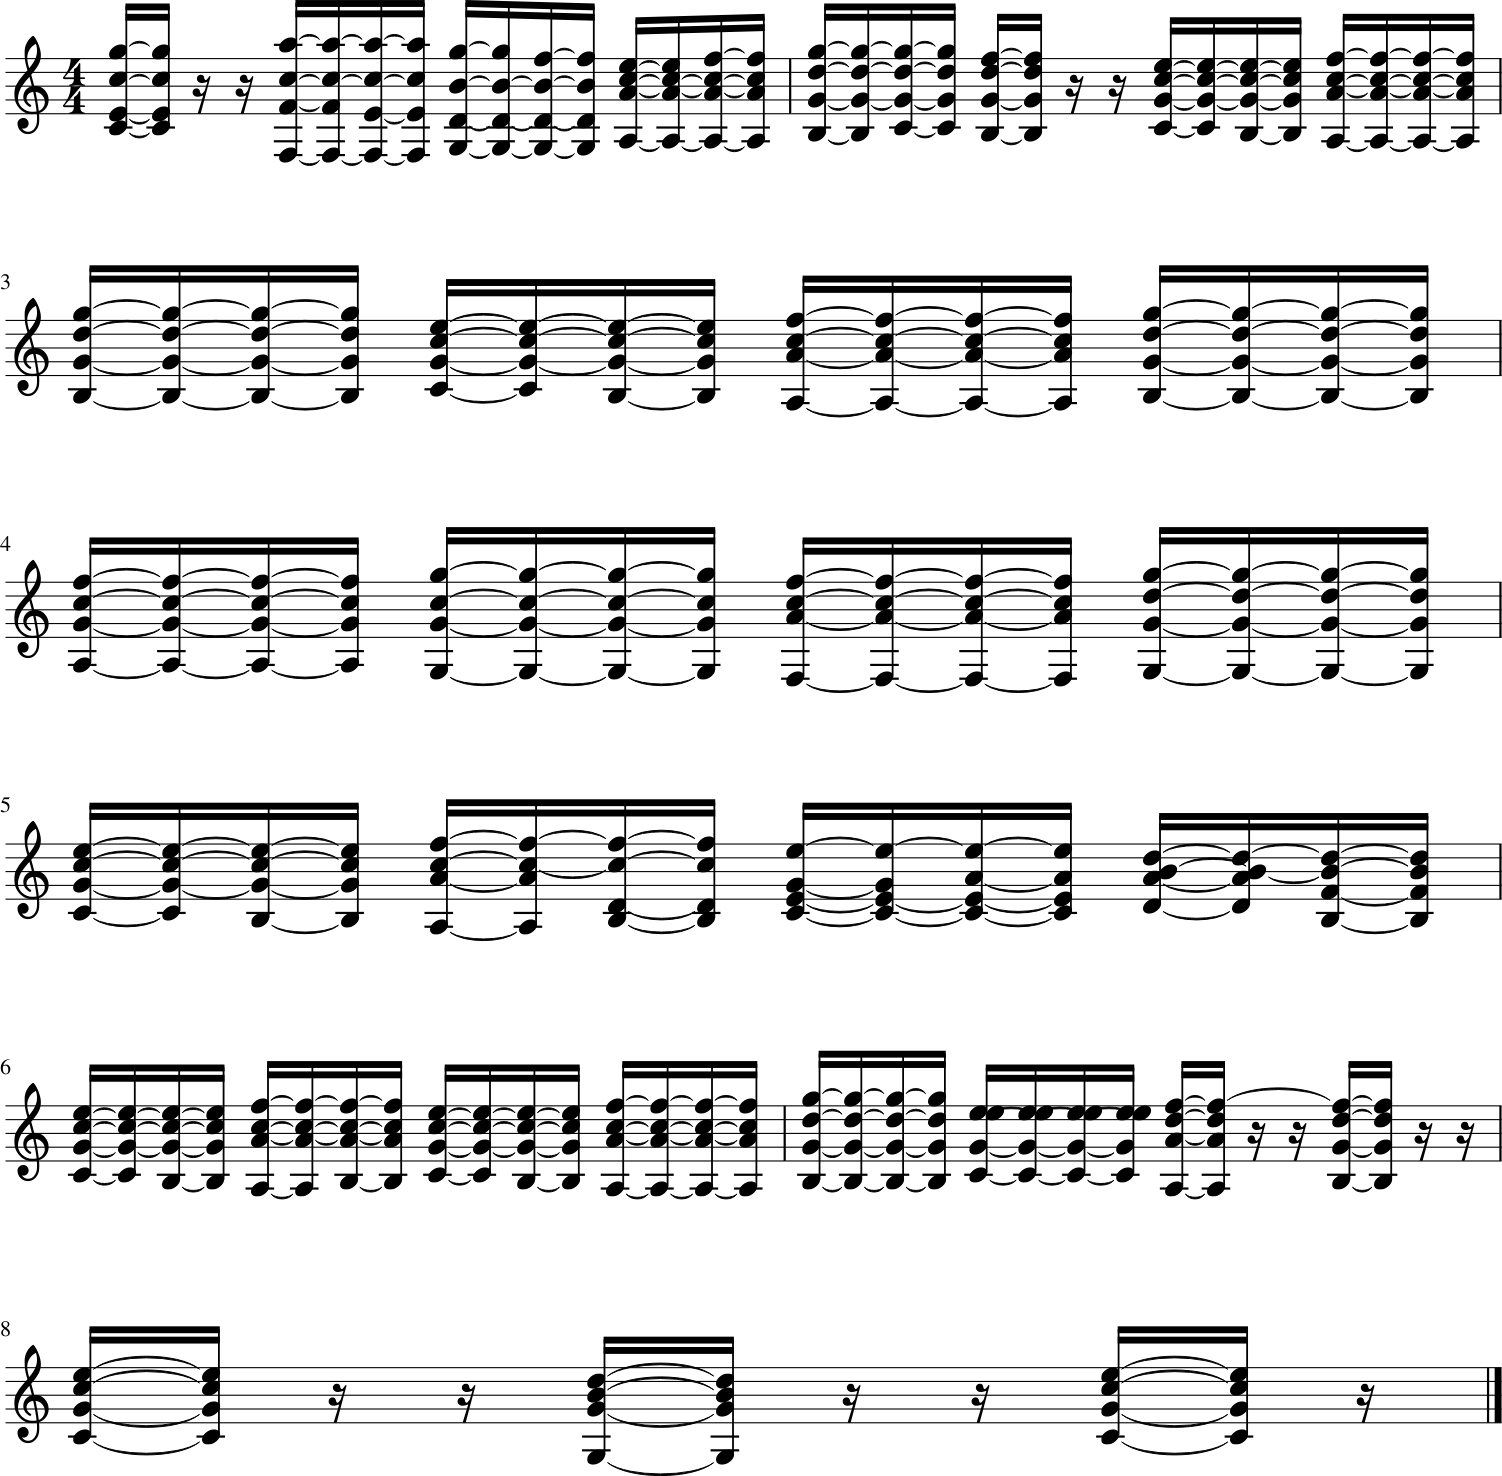

In [41]:
stream.show()

In [ ]:
fp = stream.write('midi', fp=f'{OUT_DIR}/testout.midi')

In [42]:
fp = stream.write('xml', fp=f'{OUT_DIR}/testout7.xml')

In [43]:
from IPython.lib.display import FileLink
FileLink('../data/bachbot/out/testout7.xml')

/home/paperspace/music_rnn/data/bachbot/out/testout7.xml